# 此份代码来源
https://www.kaggle.com/aralsarrafi/flowers-resnet50-tensorflow
# 待学习链接
https://blog.csdn.net/wf592523813/article/details/94478006?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param

https://www.baidu.com/link?url=5VywaI7fOaH1nVJXM8oTTZ5fO_bTA2WtSrEMOdY_YrfcGDTpAQ3wSwNdIBnaIAnOeOiv9Y4EJo4xhASOcJCnra&wd=&eqid=a9c857cc000428a7000000065faf5585

https://www.cnblogs.com/hutao722/p/10008581.html 【从这里来看，依然是个尝试的过程？】

https://www.zhihu.com/question/273633408/answer/369134332 【关于ImageNet数据集】

https://www.cnblogs.com/BlueBlueSea/p/11067521.html 【对于dropout的别人的尝试】

https://blog.csdn.net/qq_27292549/article/details/81092653 【不确定值不值得看，大概率不值得】

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow.compat.v1 as tf
import keras as K
import pandas as pd
import os

os.environ['CUDA_VISIBLE_DEVICES']='1'
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import backend
# from numba import cuda
from keras.models import load_model
import time 
%matplotlib inline 

Using TensorFlow backend.


In [2]:
# import tensorflow as tf # tf.__version__ == 2.1.0, keras.__version__ == 2.3.1
# https://blog.csdn.net/u012388993/article/details/102573008
# import keras.backend.tensorflow_backend as ktf
# https://blog.csdn.net/zuoyouzouzou/article/details/104329286
import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras.backend as ktf

# GPU 显存自动调用
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
ktf.set_session(session)

In [3]:
train_path = r'flowers_google'
labels_path = "flowers_label.csv"
ids_path = "flowers_idx.csv"

In [4]:
def PrepareAnnotation(ids_path, labels_path, train_path):
    
    ids = pd.read_csv(ids_path)
    labels  = pd.read_csv(labels_path)
    
    annotation_dict = {}

    for i in range(len(ids['id'])):
        image_id = ids['id'][i]
        image_lable = ids['flower_cls'][i]
        annotation_dict[image_id] = image_lable
    
    label_dict = {}
    num_classes = 0

    for i in range(len(labels['flower_class'])):
        label_dict[labels['flower_class'][i]] = labels['label'][i]
        num_classes+=1
        
    for key, value in annotation_dict.items():
        annotation_dict[key] = label_dict[value]
    
    image_pathes = []
    targets = []
    
    for key, value in annotation_dict.items():
        
        image_name = str(key) + ".jpeg"
        image_path = os.path.join(train_path, image_name)
        image_pathes.append(image_path)
        targets.append(value)
    
    return image_pathes, targets, num_classes

In [5]:
image_pathes, targets, num_classes = PrepareAnnotation(ids_path, labels_path, train_path)

In [6]:
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(image_pathes, targets, test_size=val_ratio, random_state=42, shuffle = True, stratify = targets)
print("num_train = ", len(x_train))
print("num_valid = ", len(x_val))

num_train =  13172
num_valid =  3293


In [7]:
def SelectSamplesForEachClass(x_train, y_train, num_examples):
    class_image_path = {}
    
    for i in range(len(y_train)):
        if (y_train[i] in class_image_path):
            if len(class_image_path[y_train[i]]) < num_examples:
                   class_image_path[y_train[i]].append(x_train[i])
        
        else:
            class_image_path[y_train[i]] = [x_train[i]]        
    
    return class_image_path

# 仅仅是展示数据集中的某些图像

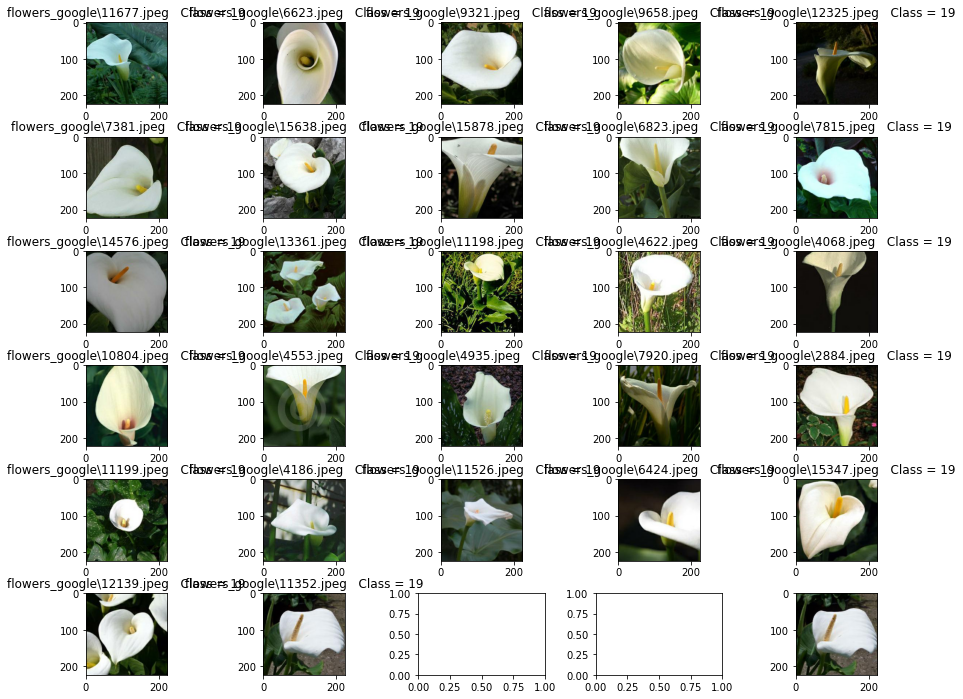

In [8]:
class_label = 19 # Try other Classes.
num_examples_to_show = 30

class_image_path_ = SelectSamplesForEachClass(x_train, y_train, num_examples_to_show)

images = class_image_path_[class_label]

fig, ax = plt.subplots(6,5, figsize=(15,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax = ax.ravel()
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    
    plt.imshow(img)
    
    title_txt = image.split("/")[-1] + "   " + "Class = " + str(class_label)
    ax[i].set_title(title_txt)
    i+=1

In [9]:
def Generator(X, Y, batch_size=16, mode='test'):
    iter_index=0
    while True:
        if mode=='test':
            index_end = min((iter_index+1)*batch_size,len(X))
            indexes = np.arange(iter_index*batch_size,index_end)
            if (iter_index+1)*batch_size >= len(X):  # 防止下一个epoch崩溃
                iter_index = 0

            iter_index+=1
        else:
            indexes = np.random.choice(len(X), batch_size)
        x = []
        y = []
    
        for index in indexes:
            x.append(X[index]) 
            y.append(Y[index])
        
        x_batch = []
        
        y_batch = K.utils.to_categorical(y, num_classes= num_classes)
        
        for i in range(len(x)):
            image = cv2.imread(x[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = K.applications.resnet50.preprocess_input(image)
            x_batch.append(image)
        
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [10]:
def ResNet50Model():
    model = K.applications.ResNet50(include_top=False, weights="imagenet", input_shape =(224, 224, 3))
    
    new_output = K.layers.GlobalAveragePooling2D()(model.output)
    new_output = K.layers.Dense(num_classes, activation = 'softmax')(new_output)
    
    model = K.engine.training.Model(model.inputs, new_output)
    
    return model

In [11]:
model = ResNet50Model()

C:\Users\Admin\anaconda3\envs\keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
# Freez first 168 Layers Except the Batch Normalization ones.
num_feerezed_layer = 168

for layer in model.layers:
    layer.trainable = True
    
    if isinstance(layer, K.layers.BatchNormalization):
        # Set Batch Norm momentun to 0.9 to faster adapt to the new DataSet.
        layer.momentum = 0.9

for layer in model.layers[:num_feerezed_layer]:
    
    if not isinstance(layer, K.layers.BatchNormalization):
        layer.trainable = False
        
# Check if the trainable layers are set Correctly
# for layer in model.layers:
#     print(layer.name, " ", "trainable = ", layer.trainable)

In [13]:
batch_size = 64 # Tesla 上占用17205MB
model_root = 'models/models_'+str(batch_size)
checkpoint = ModelCheckpoint(os.path.join(model_root,'Best_Model.h5'),
                             verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

In [14]:
model.compile(loss='categorical_crossentropy', optimizer = K.optimizers.Adamax(lr=0.01), metrics=['accuracy'])

In [15]:
from tqdm import tqdm 

if not os.path.exists(model_root):
    os.makedirs(model_root)
    
train_losses = [] 
train_accs = [] 
test_losses = []
test_accs = [] 
train_indices = [] 
test_indices = [] 
test_loss_temp_restore = [] 
test_acc_temp_restore = []
best_acc = 0
batch_num = np.ceil(len(x_train)/batch_size)
index = 0

time_begin = time.time()
for epoch in range(6):
    train_generator = Generator(x_train, y_train, batch_size)
    test_generator = Generator(x_val, y_val, 4*batch_size)
    bar = tqdm(total = batch_num, ncols=90)
    for batch, label in train_generator:
        bar.set_description_str(f'{epoch+1}/6epochs')

        index += 1
        train_loss, train_acc = model.train_on_batch(batch, label)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_indices.append(index)
        if (index-1)%30==0:
            test_loss=test_acc=0
            test_times = np.ceil(len(x_val)/4/batch_size)
#             bar_test = tqdm(total=test_times, ncols = 90)
            bar.set_description_str('val')
            test_loss_temp_ls = []
            test_acc_temp_ls = []
            for test_index in range(int(test_times)):
                batch, label = next(test_generator)
                test_loss_temp, test_acc_temp = model.test_on_batch(batch, label)
                test_loss_temp_ls.append(test_loss_temp)
                test_acc_temp_ls.append(test_acc_temp)
                test_loss+=test_loss_temp 
                test_acc+=test_acc_temp
                bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(test_loss_temp,test_acc_temp*100))
#                 bar_test.update(1)
                if test_index == test_times-1:
                    break
            test_loss_temp_restore.append(test_loss_temp_ls)
            test_acc_temp_restore.append(test_acc_temp_ls)
            test_loss = test_loss/test_times
            test_acc = test_acc/test_times
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            test_indices.append(index)
            
            
            if test_acc > 0.8 and test_acc >= best_acc:
                model.save(os.path.join(model_root, 'flower_{}_{}_{:.4f}.h5'.format(epoch, index, test_acc)))
                model.save(os.path.join(model_root, 'Best_Model.h5'))
                best_acc = test_acc
        bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(train_loss,train_acc*100))
        bar.update(1)
        if index % batch_num == 0:
            bar.moveto(0)
            break
time_end = time.time()
# model.fit(Generator(x_train, y_train, batch_size), 
#           steps_per_epoch=len(x_train)//batch_size,
#           epochs= 4,
#           validation_data=Generator(x_val, y_val, batch_size),
#           validation_steps=len(x_val) // batch_size,
#           callbacks=[checkpoint])

1/6epochs: 100%|███████████████| 206/206.0 [03:35<00:00,  1.49it/s, loss:0.82, acc:78.85%]
1/6epochs: 100%|███████████████| 206/206.0 [03:35<00:00,  1.05s/it, loss:0.82, acc:78.85%]

2/6epochs:   0%|                                                | 0/206.0 [00:00<?, ?it/s]
2/6epochs:   0%|                         | 0/206.0 [00:00<?, ?it/s, loss:0.18, acc:96.88%]
2/6epochs:   0%|                 | 1/206.0 [00:00<01:35,  2.15it/s, loss:0.18, acc:96.88%]
2/6epochs:   0%|                 | 1/206.0 [00:00<01:35,  2.15it/s, loss:0.18, acc:96.88%]
2/6epochs:   0%|                 | 1/206.0 [00:00<01:35,  2.15it/s, loss:0.09, acc:98.44%]
2/6epochs:   1%|▏                | 2/206.0 [00:00<01:32,  2.21it/s, loss:0.09, acc:98.44%]
2/6epochs:   1%|▏                | 2/206.0 [00:01<01:32,  2.21it/s, loss:0.09, acc:98.44%]
2/6epochs:   1%|▏                | 2/206.0 [00:01<01:32,  2.21it/s, loss:0.15, acc:95.31%]
2/6epochs:   1%|▏                | 3/206.0 [00:01<01:32,  2.20it/s, loss:0.15, acc:95.31%

2/6epochs:  23%|███▋            | 48/206.0 [00:52<01:20,  1.97it/s, loss:0.34, acc:89.06%]
2/6epochs:  23%|███▋            | 48/206.0 [00:52<01:20,  1.97it/s, loss:0.26, acc:92.19%]
2/6epochs:  24%|███▊            | 49/206.0 [00:52<01:16,  2.05it/s, loss:0.26, acc:92.19%]
2/6epochs:  24%|███▊            | 49/206.0 [00:52<01:16,  2.05it/s, loss:0.26, acc:92.19%]
2/6epochs:  24%|███▊            | 49/206.0 [00:52<01:16,  2.05it/s, loss:0.28, acc:93.75%]
2/6epochs:  24%|███▉            | 50/206.0 [00:52<01:14,  2.08it/s, loss:0.28, acc:93.75%]
2/6epochs:  24%|███▉            | 50/206.0 [00:52<01:14,  2.08it/s, loss:0.28, acc:93.75%]
2/6epochs:  24%|███▉            | 50/206.0 [00:53<01:14,  2.08it/s, loss:0.20, acc:92.19%]
2/6epochs:  25%|███▉            | 51/206.0 [00:53<01:12,  2.14it/s, loss:0.20, acc:92.19%]
2/6epochs:  25%|███▉            | 51/206.0 [00:53<01:12,  2.14it/s, loss:0.20, acc:92.19%]
2/6epochs:  25%|███▉            | 51/206.0 [00:53<01:12,  2.14it/s, loss:0.16, acc:96.88%]

2/6epochs:  47%|███████▌        | 97/206.0 [01:54<06:11,  3.41s/it, loss:0.28, acc:93.75%]
2/6epochs:  47%|███████▌        | 97/206.0 [01:54<06:11,  3.41s/it, loss:0.28, acc:93.75%]
2/6epochs:  47%|███████▌        | 97/206.0 [01:55<06:11,  3.41s/it, loss:0.11, acc:98.44%]
2/6epochs:  48%|███████▌        | 98/206.0 [01:55<04:34,  2.54s/it, loss:0.11, acc:98.44%]
2/6epochs:  48%|███████▌        | 98/206.0 [01:55<04:34,  2.54s/it, loss:0.11, acc:98.44%]
2/6epochs:  48%|███████▌        | 98/206.0 [01:55<04:34,  2.54s/it, loss:0.08, acc:98.44%]
2/6epochs:  48%|███████▋        | 99/206.0 [01:55<03:27,  1.94s/it, loss:0.08, acc:98.44%]
2/6epochs:  48%|███████▋        | 99/206.0 [01:56<03:27,  1.94s/it, loss:0.08, acc:98.44%]
2/6epochs:  48%|███████▋        | 99/206.0 [01:56<03:27,  1.94s/it, loss:0.13, acc:98.44%]
2/6epochs:  49%|███████▎       | 100/206.0 [01:56<02:42,  1.53s/it, loss:0.13, acc:98.44%]
2/6epochs:  49%|███████▎       | 100/206.0 [01:56<02:42,  1.53s/it, loss:0.13, acc:98.44%]

2/6epochs:  73%|██████████▉    | 150/206.0 [02:37<00:31,  1.81it/s, loss:0.15, acc:95.31%]
2/6epochs:  73%|██████████▏   | 150/206.0 [02:37<00:31,  1.81it/s, loss:0.08, acc:100.00%]
2/6epochs:  73%|██████████▎   | 151/206.0 [02:37<00:29,  1.85it/s, loss:0.08, acc:100.00%]
2/6epochs:  73%|██████████▎   | 151/206.0 [02:37<00:29,  1.85it/s, loss:0.08, acc:100.00%]
2/6epochs:  73%|██████████▉    | 151/206.0 [02:38<00:29,  1.85it/s, loss:0.21, acc:93.75%]
2/6epochs:  74%|███████████    | 152/206.0 [02:38<00:27,  1.95it/s, loss:0.21, acc:93.75%]
2/6epochs:  74%|███████████    | 152/206.0 [02:38<00:27,  1.95it/s, loss:0.21, acc:93.75%]
2/6epochs:  74%|███████████    | 152/206.0 [02:38<00:27,  1.95it/s, loss:0.15, acc:98.44%]
2/6epochs:  74%|███████████▏   | 153/206.0 [02:38<00:26,  1.99it/s, loss:0.15, acc:98.44%]
2/6epochs:  74%|███████████▏   | 153/206.0 [02:38<00:26,  1.99it/s, loss:0.15, acc:98.44%]
2/6epochs:  74%|███████████▏   | 153/206.0 [02:39<00:26,  1.99it/s, loss:0.17, acc:95.31%]

2/6epochs:  97%|██████████████▍| 199/206.0 [03:26<00:03,  2.06it/s, loss:0.19, acc:93.75%]
2/6epochs:  97%|██████████████▍| 199/206.0 [03:26<00:03,  2.06it/s, loss:0.19, acc:93.75%]
2/6epochs:  97%|██████████████▍| 199/206.0 [03:26<00:03,  2.06it/s, loss:0.26, acc:93.75%]
2/6epochs:  97%|██████████████▌| 200/206.0 [03:26<00:03,  1.96it/s, loss:0.26, acc:93.75%]
2/6epochs:  97%|██████████████▌| 200/206.0 [03:26<00:03,  1.96it/s, loss:0.26, acc:93.75%]
2/6epochs:  97%|██████████████▌| 200/206.0 [03:27<00:03,  1.96it/s, loss:0.13, acc:96.88%]
2/6epochs:  98%|██████████████▋| 201/206.0 [03:27<00:02,  1.93it/s, loss:0.13, acc:96.88%]
2/6epochs:  98%|██████████████▋| 201/206.0 [03:27<00:02,  1.93it/s, loss:0.13, acc:96.88%]
2/6epochs:  98%|█████████████▋| 201/206.0 [03:27<00:02,  1.93it/s, loss:0.09, acc:100.00%]
2/6epochs:  98%|█████████████▋| 202/206.0 [03:27<00:02,  1.90it/s, loss:0.09, acc:100.00%]
2/6epochs:  98%|█████████████▋| 202/206.0 [03:28<00:02,  1.90it/s, loss:0.09, acc:100.00%]

val:  20%|████▍                 | 42/206.0 [00:39<01:15,  2.17it/s, loss:0.43, acc:89.84%]
val:  20%|████▍                 | 42/206.0 [00:40<01:15,  2.17it/s, loss:0.73, acc:84.38%]
val:  20%|████▍                 | 42/206.0 [00:41<01:15,  2.17it/s, loss:0.51, acc:88.67%]
val:  20%|████▍                 | 42/206.0 [00:42<01:15,  2.17it/s, loss:0.65, acc:87.33%]
val:  20%|████▍                 | 42/206.0 [00:43<01:15,  2.17it/s, loss:0.51, acc:87.89%]
val:  20%|████▎                | 42/206.0 [00:43<01:15,  2.17it/s, loss:0.02, acc:100.00%]
val:  21%|████▍                | 43/206.0 [00:43<10:02,  3.70s/it, loss:0.02, acc:100.00%]
4/6epochs:  21%|███▏           | 43/206.0 [00:43<10:02,  3.70s/it, loss:0.02, acc:100.00%]
4/6epochs:  21%|███▏           | 43/206.0 [00:43<10:02,  3.70s/it, loss:0.02, acc:100.00%]
4/6epochs:  21%|███▏           | 44/206.0 [00:43<07:22,  2.73s/it, loss:0.02, acc:100.00%]
4/6epochs:  21%|███▏           | 44/206.0 [00:43<07:22,  2.73s/it, loss:0.02, acc:100.00%]

4/6epochs:  46%|███████▎        | 94/206.0 [01:17<00:51,  2.16it/s, loss:0.05, acc:98.44%]
4/6epochs:  46%|██████▊        | 94/206.0 [01:17<00:51,  2.16it/s, loss:0.01, acc:100.00%]
4/6epochs:  46%|██████▉        | 95/206.0 [01:17<00:51,  2.16it/s, loss:0.01, acc:100.00%]
4/6epochs:  46%|██████▉        | 95/206.0 [01:17<00:51,  2.16it/s, loss:0.01, acc:100.00%]
4/6epochs:  46%|██████▉        | 95/206.0 [01:18<00:51,  2.16it/s, loss:0.01, acc:100.00%]
4/6epochs:  47%|██████▉        | 96/206.0 [01:18<00:50,  2.16it/s, loss:0.01, acc:100.00%]
4/6epochs:  47%|██████▉        | 96/206.0 [01:18<00:50,  2.16it/s, loss:0.01, acc:100.00%]
4/6epochs:  47%|██████▉        | 96/206.0 [01:18<00:50,  2.16it/s, loss:0.01, acc:100.00%]
4/6epochs:  47%|███████        | 97/206.0 [01:18<00:49,  2.18it/s, loss:0.01, acc:100.00%]
4/6epochs:  47%|███████        | 97/206.0 [01:18<00:49,  2.18it/s, loss:0.01, acc:100.00%]
4/6epochs:  47%|███████        | 97/206.0 [01:18<00:49,  2.18it/s, loss:0.01, acc:100.00%]

4/6epochs:  69%|██████████▍    | 143/206.0 [02:03<00:36,  1.75it/s, loss:0.06, acc:98.44%]
4/6epochs:  69%|██████████▍    | 143/206.0 [02:03<00:36,  1.75it/s, loss:0.06, acc:98.44%]
4/6epochs:  69%|█████████▋    | 143/206.0 [02:04<00:36,  1.75it/s, loss:0.01, acc:100.00%]
4/6epochs:  70%|█████████▊    | 144/206.0 [02:04<00:33,  1.85it/s, loss:0.01, acc:100.00%]
4/6epochs:  70%|█████████▊    | 144/206.0 [02:04<00:33,  1.85it/s, loss:0.01, acc:100.00%]
4/6epochs:  70%|█████████▊    | 144/206.0 [02:04<00:33,  1.85it/s, loss:0.03, acc:100.00%]
4/6epochs:  70%|█████████▊    | 145/206.0 [02:04<00:32,  1.86it/s, loss:0.03, acc:100.00%]
4/6epochs:  70%|█████████▊    | 145/206.0 [02:04<00:32,  1.86it/s, loss:0.03, acc:100.00%]
4/6epochs:  70%|█████████▊    | 145/206.0 [02:05<00:32,  1.86it/s, loss:0.01, acc:100.00%]
4/6epochs:  71%|█████████▉    | 146/206.0 [02:05<00:33,  1.82it/s, loss:0.01, acc:100.00%]
4/6epochs:  71%|█████████▉    | 146/206.0 [02:05<00:33,  1.82it/s, loss:0.01, acc:100.00%]

val:  93%|███████████████████▌ | 192/206.0 [02:54<00:06,  2.16it/s, loss:0.58, acc:86.72%]
val:  93%|███████████████████▌ | 192/206.0 [02:55<00:06,  2.16it/s, loss:0.48, acc:88.67%]
val:  93%|███████████████████▌ | 192/206.0 [02:56<00:06,  2.16it/s, loss:0.53, acc:89.45%]
val:  93%|██████████████████▋ | 192/206.0 [02:56<00:06,  2.16it/s, loss:0.02, acc:100.00%]
val:  94%|██████████████████▋ | 193/206.0 [02:56<00:47,  3.65s/it, loss:0.02, acc:100.00%]
4/6epochs:  94%|█████████████ | 193/206.0 [02:56<00:47,  3.65s/it, loss:0.02, acc:100.00%]
4/6epochs:  94%|█████████████ | 193/206.0 [02:56<00:47,  3.65s/it, loss:0.01, acc:100.00%]
4/6epochs:  94%|█████████████▏| 194/206.0 [02:56<00:32,  2.69s/it, loss:0.01, acc:100.00%]
4/6epochs:  94%|█████████████▏| 194/206.0 [02:56<00:32,  2.69s/it, loss:0.01, acc:100.00%]
4/6epochs:  94%|█████████████▏| 194/206.0 [02:56<00:32,  2.69s/it, loss:0.01, acc:100.00%]
4/6epochs:  95%|█████████████▎| 195/206.0 [02:56<00:22,  2.02s/it, loss:0.01, acc:100.00%]

6/6epochs:  18%|██▊            | 38/206.0 [00:29<01:17,  2.17it/s, loss:0.01, acc:100.00%]
6/6epochs:  18%|██▊            | 38/206.0 [00:29<01:17,  2.17it/s, loss:0.01, acc:100.00%]
6/6epochs:  19%|██▊            | 39/206.0 [00:29<01:17,  2.16it/s, loss:0.01, acc:100.00%]
6/6epochs:  19%|██▊            | 39/206.0 [00:29<01:17,  2.16it/s, loss:0.01, acc:100.00%]
6/6epochs:  19%|███             | 39/206.0 [00:30<01:17,  2.16it/s, loss:0.03, acc:98.44%]
6/6epochs:  19%|███             | 40/206.0 [00:30<01:16,  2.16it/s, loss:0.03, acc:98.44%]
6/6epochs:  19%|███             | 40/206.0 [00:30<01:16,  2.16it/s, loss:0.03, acc:98.44%]
6/6epochs:  19%|███             | 40/206.0 [00:30<01:16,  2.16it/s, loss:0.03, acc:98.44%]
6/6epochs:  20%|███▏            | 41/206.0 [00:30<01:15,  2.19it/s, loss:0.03, acc:98.44%]
6/6epochs:  20%|███▏            | 41/206.0 [00:30<01:15,  2.19it/s, loss:0.03, acc:98.44%]
6/6epochs:  20%|██▉            | 41/206.0 [00:31<01:15,  2.19it/s, loss:0.00, acc:100.00%]

6/6epochs:  42%|██████▎        | 87/206.0 [01:14<01:43,  1.15it/s, loss:0.01, acc:100.00%]
6/6epochs:  42%|██████▎        | 87/206.0 [01:14<01:43,  1.15it/s, loss:0.01, acc:100.00%]
6/6epochs:  42%|██████▎        | 87/206.0 [01:14<01:43,  1.15it/s, loss:0.01, acc:100.00%]
6/6epochs:  43%|██████▍        | 88/206.0 [01:14<01:28,  1.33it/s, loss:0.01, acc:100.00%]
6/6epochs:  43%|██████▍        | 88/206.0 [01:14<01:28,  1.33it/s, loss:0.01, acc:100.00%]
6/6epochs:  43%|██████▍        | 88/206.0 [01:15<01:28,  1.33it/s, loss:0.02, acc:100.00%]
6/6epochs:  43%|██████▍        | 89/206.0 [01:15<01:17,  1.51it/s, loss:0.02, acc:100.00%]
6/6epochs:  43%|██████▍        | 89/206.0 [01:15<01:17,  1.51it/s, loss:0.02, acc:100.00%]
6/6epochs:  43%|██████▍        | 89/206.0 [01:15<01:17,  1.51it/s, loss:0.01, acc:100.00%]
6/6epochs:  44%|██████▌        | 90/206.0 [01:15<01:08,  1.68it/s, loss:0.01, acc:100.00%]
6/6epochs:  44%|██████▌        | 90/206.0 [01:15<01:08,  1.68it/s, loss:0.01, acc:100.00%]

6/6epochs:  68%|█████████▌    | 140/206.0 [01:49<00:30,  2.20it/s, loss:0.00, acc:100.00%]
val:  68%|█████████████▌      | 140/206.0 [01:49<00:30,  2.20it/s, loss:0.00, acc:100.00%]
val:  68%|██████████████▎      | 140/206.0 [01:50<00:30,  2.20it/s, loss:0.62, acc:89.45%]
val:  68%|██████████████▎      | 140/206.0 [01:51<00:30,  2.20it/s, loss:0.54, acc:86.72%]
val:  68%|██████████████▎      | 140/206.0 [01:52<00:30,  2.20it/s, loss:0.56, acc:88.28%]
val:  68%|██████████████▎      | 140/206.0 [01:53<00:30,  2.20it/s, loss:0.62, acc:89.45%]
val:  68%|██████████████▎      | 140/206.0 [01:53<00:30,  2.20it/s, loss:0.55, acc:89.84%]
val:  68%|██████████████▎      | 140/206.0 [01:54<00:30,  2.20it/s, loss:0.49, acc:88.67%]
val:  68%|██████████████▎      | 140/206.0 [01:55<00:30,  2.20it/s, loss:0.86, acc:81.64%]
val:  68%|██████████████▎      | 140/206.0 [01:56<00:30,  2.20it/s, loss:0.48, acc:89.45%]
val:  68%|██████████████▎      | 140/206.0 [01:57<00:30,  2.20it/s, loss:0.58, acc:89.59%]

6/6epochs:  92%|████████████▊ | 189/206.0 [02:34<00:07,  2.19it/s, loss:0.00, acc:100.00%]
6/6epochs:  92%|████████████▊ | 189/206.0 [02:35<00:07,  2.19it/s, loss:0.00, acc:100.00%]
6/6epochs:  92%|████████████▊ | 189/206.0 [02:35<00:07,  2.19it/s, loss:0.01, acc:100.00%]
6/6epochs:  92%|████████████▉ | 190/206.0 [02:35<00:07,  2.21it/s, loss:0.01, acc:100.00%]
6/6epochs:  92%|████████████▉ | 190/206.0 [02:35<00:07,  2.21it/s, loss:0.01, acc:100.00%]
6/6epochs:  92%|████████████▉ | 190/206.0 [02:35<00:07,  2.21it/s, loss:0.01, acc:100.00%]
6/6epochs:  93%|████████████▉ | 191/206.0 [02:35<00:07,  2.03it/s, loss:0.01, acc:100.00%]
6/6epochs:  93%|████████████▉ | 191/206.0 [02:36<00:07,  2.03it/s, loss:0.01, acc:100.00%]
6/6epochs:  93%|████████████▉ | 191/206.0 [02:36<00:07,  2.03it/s, loss:0.01, acc:100.00%]
6/6epochs:  93%|█████████████ | 192/206.0 [02:36<00:06,  2.10it/s, loss:0.01, acc:100.00%]
6/6epochs:  93%|█████████████ | 192/206.0 [02:36<00:06,  2.10it/s, loss:0.01, acc:100.00%]

In [16]:
print('time used is', (time_end-time_begin)/60)

history_root = 'history/history_'+str(batch_size)
if not os.path.exists(history_root):
    os.makedirs(history_root)
    
for i in ['train_losses','train_accs','test_losses','test_accs',
          'train_indices','test_indices','test_loss_temp_restore',
          'test_acc_temp_restore']:
    np.save(os.path.join(history_root,i), eval(i))

time used is 19.33603353500366


In [17]:
model = load_model(os.path.join(model_root, "Best_Model.h5"))
test_accuracy = model.evaluate_generator(Generator(x_val, y_val, batch_size), len(x_val) // batch_size)[1]
print(test_accuracy)

0.8829656839370728


In [18]:
def VisualizePrediction(path, gt_label):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    
    image = K.applications.resnet50.preprocess_input(image)
    image = np.expand_dims(image, axis = 0)
    
    probabilities = model.predict(image)
    predicted_label = np.argmax(probabilities, axis = 1)
    
    title_txt = "Prediction = " + str(predicted_label[0]) + "     " + "gt = " + str(gt_label)
    plt.title(title_txt)

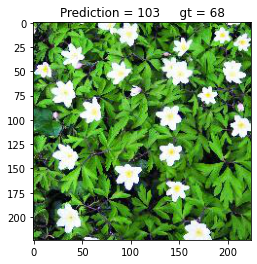

In [19]:
sample = 500 # Try different Samples
image_path = x_val[sample]
gt_label = y_val[sample]

# Make Predictions on Training Data set.
# image_path = x_train[sample]
# gt_label = y_train[sample]

VisualizePrediction(image_path, gt_label)

# 训练曲线可视化

In [20]:
import numpy as np 
from matplotlib import pyplot as plt 
%matplotlib inline 

train_losses = np.load(os.path.join(history_root,'train_losses.npy'),allow_pickle =True)
train_accs = np.load(os.path.join(history_root,'train_accs.npy'),allow_pickle=True)
test_losses = np.load(os.path.join(history_root, 'test_losses.npy'),allow_pickle=True)
test_accs = np.load(os.path.join(history_root,'test_accs.npy'),allow_pickle=True)
train_indices = np.load(os.path.join(history_root, 'train_indices.npy'),allow_pickle=True)
test_indices = np.load(os.path.join(history_root, 'test_indices.npy'),allow_pickle=True)

In [21]:
# plt.plot(train_losses)
# plt.plot(np.arange(1,min(len(train_losses),len(test_accs)*30)+1,30),test_losses,'red',label='test')

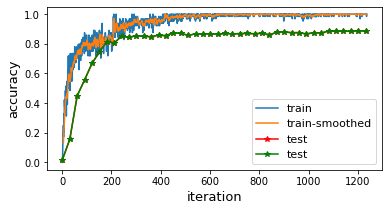

In [28]:
plt.figure(figsize = (6,3))
plt.plot(np.arange(1,len(train_accs)+1),train_accs,label='train')

train_accs_smoothing = [] 
smooth_num = 5
for i in range(len(train_accs)-smooth_num):
    begin_index = i
    end_index = i+smooth_num
    temp = train_accs[begin_index:end_index]
    train_accs_smoothing.append(np.mean(temp))
plt.plot(np.arange(smooth_num,len(train_accs)),train_accs_smoothing,label='train-smoothed')
plt.plot(np.arange(1,min(len(train_accs),len(test_accs-1)*30+1)+1,30),test_accs,'r-*',label='test')
# test_accs = np.load(os.path.join('history/history_64_noperfect','test_accs.npy'),allow_pickle=True)
# plt.plot(np.arange(1,min(len(train_accs),len(test_accs-1)*30+1)+1,30),test_accs,'g-*',label='test')

plt.legend(fontsize=11)
plt.ylabel('accuracy',fontsize=13)
plt.xlabel('iteration',fontsize=13)
# plt.xlim(0,4000)
plt.savefig('curves.png',dpi=200,bbox_inches='tight')